In [51]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D, Dropout
from keras.layers.convolutional import Conv1D, Conv2D
from keras.optimizers import SGD, Adam
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile

In [52]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Load the audio data

In [53]:
multitracks = mdb.load_multitracks([
    "Phoenix_ColliersDaughter", 
    "Phoenix_BrokenPledgeChicagoReel", 
    "Phoenix_ElzicsFarewell", 
    "Phoenix_LarkOnTheStrandDrummondCastle",
    "Phoenix_ScotchMorris",
    "Phoenix_SeanCaughlinsTheScartaglen"
])

In [54]:
mix_audio = None
instrument_audio = None

for mix in multitracks:
    sample_rate, song = wavfile.read(mix.mix_path)
    
    if mix_audio is None:
        mix_audio = song
    
    else:
        mix_audio = np.concatenate((mix_audio, song))
    
    #
    
    instruments = mdb.get_files_for_instrument("violin", [mix])

    instrument = next(instruments)
    
    sample_rate, track = wavfile.read(instrument)
    
    if instrument_audio is None:
        instrument_audio = track
    
    else:
        instrument_audio = np.concatenate((instrument_audio, track))
    
mix_audio = mix_audio.mean(1)
instrument_audio = instrument_audio.mean(1)

In [55]:
samples_per_period = 256
overlap = int(samples_per_period/2)

# Process the Mix

In [56]:
freqs, times, s_mix = signal.stft(mix_audio, fs=sample_rate, nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

In [57]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))
#plt.title("STFT of the Mix")
#plt.ylabel("Frequency (Hz)")
#plt.xlabel("Time (s)")

# Process the Target Instrument

In [ ]:
freqs, times, s_instrument = signal.stft(instrument_audio, fs=sample_rate, nfft=samples_per_period, 
                                               noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_instrument = s_instrument[:-1,:]
s_instrument += 1e-9

In [ ]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_instrument)))
#plt.title("STFT of the instrument Track")
#plt.xlabel("Time (s)")
#plt.ylabel("Frequency (Hz)")

# Prepare the training data

In [ ]:
num_test  = int((sample_rate * 120)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

374742 20671


In [ ]:
mix_train = s_mix.T[:num_train,np.newaxis,:]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=1)
mix_train.shape

(374742, 2, 128)

In [ ]:
instrument_train = s_instrument.T[:num_train,np.newaxis,:]
instrument_train = np.concatenate((instrument_train.real, instrument_train.imag), axis=1)
instrument_train.shape

(374742, 2, 128)

In [ ]:
mix_test = s_mix.T[-num_test:,np.newaxis,:]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=1)
mix_test.shape

(20671, 2, 128)

In [ ]:
instrument_test = s_instrument.T[-num_test:,np.newaxis,:]
instrument_test = np.concatenate((instrument_test.real, instrument_test.imag), axis=1)
instrument_test.shape

(20671, 2, 128)

In [ ]:
model = Sequential()

model.add(Dense(128, input_shape=mix_train.shape[1:]))

model.add(Dropout(0.3))

model.add(UpSampling1D(4))

model.add(Conv1D(128, 2, padding="same", activation="relu"))
model.add(MaxPooling1D(2, padding="same"))
model.add(Conv1D(64, 2, padding="same",  activation="relu"))
model.add(MaxPooling1D(2, padding="same"))
model.add(Conv1D(32, 2, padding="same",  activation="relu"))
model.add(MaxPooling1D(2, padding="same"))
model.add(Dense(32))
model.add(Conv1D(32, 2, padding="same",  activation="relu"))
model.add(UpSampling1D(2))
model.add(Conv1D(64, 2, padding="same",  activation="relu"))
model.add(UpSampling1D(2))
model.add(Conv1D(128, 2, padding="same",  activation="relu"))
model.add(UpSampling1D(2))

model.add(Dropout(0.3))

model.add(Dense(128))

model.add(Conv1D(128, 2, padding="same", activation="relu"))
model.add(MaxPooling1D(2, padding="same"))
model.add(Conv1D(64, 2, padding="same",  activation="relu"))
model.add(MaxPooling1D(2, padding="same"))
model.add(Conv1D(32, 2, padding="same",  activation="relu"))
model.add(MaxPooling1D(2, padding="same"))
model.add(Dense(32))
model.add(Conv1D(32, 2, padding="same",  activation="relu"))
model.add(UpSampling1D(2))
model.add(Conv1D(64, 2, padding="same",  activation="relu"))
model.add(Conv1D(128, 2, padding="same",  activation="relu"))

model.add(Dropout(0.3))

model.add(Dense(128))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 2, 128)            16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 2, 128)            0         
_________________________________________________________________
up_sampling1d_11 (UpSampling (None, 8, 128)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 8, 128)            32896     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 4, 128)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 4, 64)             16448     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 2, 64)             0         
__________

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#sgd = SGD(lr=0.001, momentum=1.1, decay=1.1, nesterov=True)

model.compile(adam, loss='mean_squared_error', metrics=['accuracy'])

In [69]:
history = model.fit(mix_train, instrument_train, batch_size=1000, epochs=1000)

Epoch 1/1000
374742/374742 [==============================] - 12s 33us/step - loss: 1414.3723 - acc: 0.4235
Epoch 2/1000
237000/374742 [=================>............] - ETA: 4s - loss: 1416.2137 - acc: 0.4234

KeyboardInterrupt: 

In [76]:
history.history

{'loss': [2651.4974292329343,
  2226.8391062431187,
  2067.214454991563,
  1946.174121658377,
  1837.1672057038572,
  1793.415758011062,
  1762.400142956074,
  1735.0436966372542,
  1707.1457021079,
  1682.0663565061486,
  1662.8216527351378,
  1647.2470544981952,
  1634.3882021525637,
  1623.6451019906356,
  1613.7167949909317,
  1604.0206248353888,
  1593.6743279267585,
  1584.3778725547386,
  1577.1128856253456,
  1567.2965782973333,
  1560.8920284226317,
  1554.1272922271135,
  1547.3245153844248,
  1538.7096101353723,
  1531.638312686049,
  1522.221341231706,
  1516.651151752459,
  1509.0359857305639,
  1501.5619947725206,
  1495.7443859677694,
  1490.5248843793327,
  1484.5718696240265,
  1479.1091385499337,
  1470.5150698323505,
  1466.4782176450242,
  1461.6384709368997,
  1454.4526530873961,
  1450.1260260398126,
  1444.9426426630891,
  1440.7984386089793,
  1435.885987984226,
  1432.7996096325387,
  1429.633005220398,
  1426.0742876599186,
  1418.459871155963,
  1415.82151381

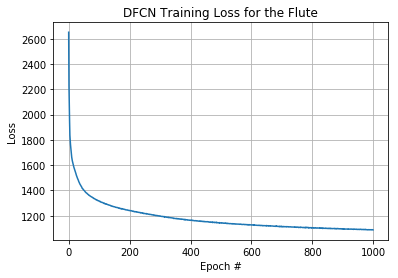

In [81]:
plt.plot(history.history['loss'])
plt.title("DFCN Training Loss for the Flute")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.grid()

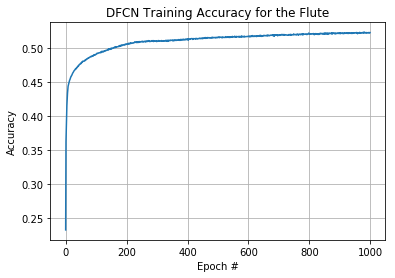

In [80]:
plt.plot(history.history['acc'])
plt.title("DFCN Training Accuracy for the Flute")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.grid()

In [70]:
results = model.evaluate(mix_test, instrument_test)

print(model.metrics_names)
print(results)

20671/20671 [==============================] - 1s 65us/step
['loss', 'acc']
[1688.775614214573, 0.4336993856026019]


# Results

In [71]:
prediction = model.predict(mix_test)
prediction.shape

(20671, 2, 128)

In [72]:
prediction = (prediction[:,0,:]+prediction[:,1,:] * 1j).T
prediction += 1e-9

In [73]:
target = s_instrument[:, -num_test:]

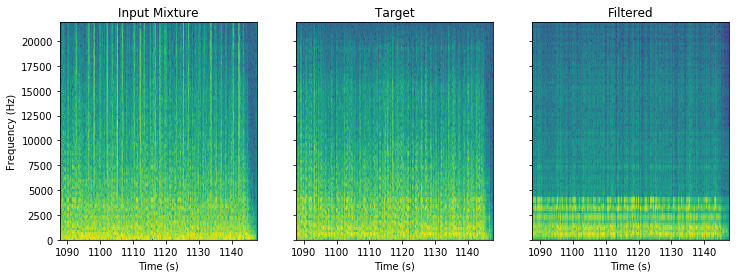

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,sharey=True,figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target")
ax3.set_title("Filtered")

ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Time (s)")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(target)))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(prediction)))

## Let's hear it

In [75]:
_, predicted_audio = signal.istft(prediction, fs=sample_rate)
_, target_audio = signal.istft(target, fs=sample_rate)
_, mix_audio = signal.istft(s_mix[:,-num_test:], fs=sample_rate)

wavfile.write("fcn_model_3_instrument_prediction.wav", sample_rate, predicted_audio.astype(np.int16))
wavfile.write("fcn_model_3_instrument_target.wav", sample_rate, target_audio.astype(np.int16))
wavfile.write("fcn_model_3_original.wav", sample_rate, mix_audio.astype(np.int16))